In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC  # Linear SVM Classifier
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
    recall_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.calibration import CalibratedClassifierCV

# Enhanced project helper with PDF content
from prepare_data_pdf_content import (
    load_clean_dataframe_with_pdf_content,
    load_enhanced_features_dataframe,
    create_modeling_dataset,
    get_code_statistics
)  # type: ignore


def threshold_for_recall(scores, y_true, recall_target=0.85):
    """Return the highest threshold that still achieves recall ≥ target."""
    prec, rec, thr = precision_recall_curve(y_true, scores)
    candidates = [t for r, t in zip(rec[:-1], thr) if r >= recall_target]
    return max(candidates) if candidates else thr.min()

In [2]:
# Load enhanced dataset with PDF content - only tenders with PDF text
print("Loading enhanced dataset with PDF content...")

# Load the modeling dataset which includes quality filters
df = create_modeling_dataset(
    labelled_only=True,
    extract_lot_section_only=True,  # Extract only 5 Lot sections
    include_codes_onehot=True,      # Include one-hot encoded codes
    min_pdf_text_length=50,         # Minimum PDF text length
    min_codes_for_analysis=0        # Include all (no minimum codes required)
)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.shape[1]}")

# Show PDF content statistics
print(f"\nPDF Content Statistics:")
print(f"Rows with PDF content: {df['has_pdf_content'].sum()}")
print(f"Rows with detected codes: {df['has_codes'].sum()}")
print(f"Average codes per document: {df['codes_count'].mean():.2f}")
print(f"Average PDF text length: {df['pdf_text_length'].mean():.0f} characters")

# Filter to only include tenders with PDF text content
df = df[df['has_pdf_content'] == 1].copy()
print(f"\nAfter filtering to PDF content only: {df.shape[0]} rows")

# Check class distribution
y = df["bid"].astype(int).values
print(f"Class distribution: {np.bincount(y)}")
print(f"Positive class ratio: {y.mean():.3f}")

# Show sample of detected codes
code_columns = [col for col in df.columns if col.startswith('code_')]
print(f"\nOne-hot encoded code columns: {len(code_columns)}")
if code_columns:
    print(f"Sample code columns: {code_columns[:5]}")
    print(f"Total codes detected across all documents: {df[code_columns].sum().sum()}")

Loading enhanced dataset with PDF content...
SQL Query: 
    SELECT 
        tr.*,
        pc.pdf_text,
        pc.detected_codes,
        pc.codes_count,
        pc.extraction_timestamp,
        pc.processing_status
    FROM tender_records tr
    LEFT JOIN pdf_content pc ON tr.resource_id = CAST(pc.resource_id AS BIGINT)
    
Dataset shape: (1443, 72)
Columns: 72

PDF Content Statistics:
Rows with PDF content: 1443
Rows with detected codes: 167
Average codes per document: 0.30
Average PDF text length: 7402 characters

After filtering to PDF content only: 1443 rows
Class distribution: [1346   97]
Positive class ratio: 0.067

One-hot encoded code columns: 54
Sample code columns: ['code_48000000', 'code_48100000', 'code_48190000', 'code_48200000', 'code_48220000']
Total codes detected across all documents: 489.42042121666077


/mnt/c/Users/rober/GitHub/module_2/python/db_utils_pdf_content.py:209: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pdf_text'].fillna("", inplace=True)
/mnt/c/Users/rober/GitHub/module_2/python/db_utils_pdf_content.py:210: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [4]:
# Enhanced preprocessing pipeline with PDF content
print("Creating enhanced preprocessing pipeline...")

# Define feature columns
cat_cols = ["ca", "procedure"]  # Categorical columns
num_cols = ["codes_count", "pdf_text_length"]  # Numerical columns
code_cols = [col for col in df.columns if col.startswith('code_')]  # Code columns

# Add code columns to numerical features
num_cols.extend(code_cols)

# Create features dataframe X (exclude target and metadata columns)
# Use a safer approach that only drops columns that actually exist
exclude_cols = ["bid", "has_pdf_content", "has_codes"]
# Add optional columns only if they exist
optional_exclude = ["resource_id", "extraction_timestamp", "processing_status"]
for col in optional_exclude:
    if col in df.columns:
        exclude_cols.append(col)

print(f"Columns to exclude: {exclude_cols}")
print(f"Available columns: {list(df.columns)}")

X = df.drop(columns=exclude_cols)

print(f"Feature matrix shape: {X.shape}")
print(f"Categorical features: {len(cat_cols)}")
print(f"Numerical features: {len(num_cols)}")
print(f"Code features: {len(code_cols)}")

# Create separate TF-IDF vectorizers for title and PDF text
title_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_features=20_000,  # Smaller for title
    strip_accents="unicode",
    lowercase=True,
)

pdf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_features=30_000,  # Larger for PDF content
    strip_accents="unicode",
    lowercase=True,
)

# Enhanced preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("title_tfidf", title_vectorizer, "title"),
        ("pdf_tfidf", pdf_vectorizer, "pdf_text"),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)

# Linear SVM with enhanced features
base_clf = LinearSVC(
    max_iter=3000,  # Increased for more complex features
    class_weight="balanced",
    dual=False,
    random_state=42,
)

# Create pipeline and add calibration for probability estimates
pipe = Pipeline([("prep", preprocess), ("clf", base_clf)])
calibrated = CalibratedClassifierCV(pipe, cv=3, method="sigmoid")

print("Enhanced pipeline created with PDF content features")
print(f"Title TF-IDF max features: {title_vectorizer.max_features:,}")
print(f"PDF TF-IDF max features: {pdf_vectorizer.max_features:,}")
print(f"Code features: {len(code_cols)}")
print(f"Total numerical features: {len(num_cols)}")

Creating enhanced preprocessing pipeline...
Columns to exclude: ['bid', 'has_pdf_content', 'has_codes', 'extraction_timestamp', 'processing_status']
Available columns: ['title', 'ca', 'procedure', 'pdf_url', 'bid', 'pdf_text', 'codes_count', 'detected_codes', 'extraction_timestamp', 'processing_status', 'code_48000000', 'code_48100000', 'code_48190000', 'code_48200000', 'code_48220000', 'code_48300000', 'code_48400000', 'code_48480000', 'code_48500000', 'code_48600000', 'code_48700000', 'code_48900000', 'code_72000000', 'code_72100000', 'code_72110000', 'code_72120000', 'code_72130000', 'code_72140000', 'code_72200000', 'code_72210000', 'code_72220000', 'code_72221000', 'code_72222000', 'code_72222100', 'code_72222200', 'code_72222300', 'code_72223000', 'code_72224000', 'code_72224200', 'code_72225000', 'code_72226000', 'code_72227000', 'code_72228000', 'code_72300000', 'code_72310000', 'code_72320000', 'code_72321000', 'code_72322000', 'code_72330000', 'code_72400000', 'code_72421000'

Running 5-fold stratified cross-validation with PDF content...


/mnt/c/Users/rober/GitHub/module_2/python/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/c/Users/rober/GitHub/module_2/python/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/c/Users/rober/GitHub/module_2/python/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/c/Users/rober/GitHub/module_2/python/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/c/Users/rober/GitHub/module_2/python/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of

Chosen threshold to hit recall ≥0.85  →  0.054

Cross-validation results with PDF content:
              precision    recall  f1-score   support

           0      0.985     0.677     0.802      1346
           1      0.160     0.856     0.270        97

    accuracy                          0.689      1443
   macro avg      0.573     0.766     0.536      1443
weighted avg      0.929     0.689     0.767      1443



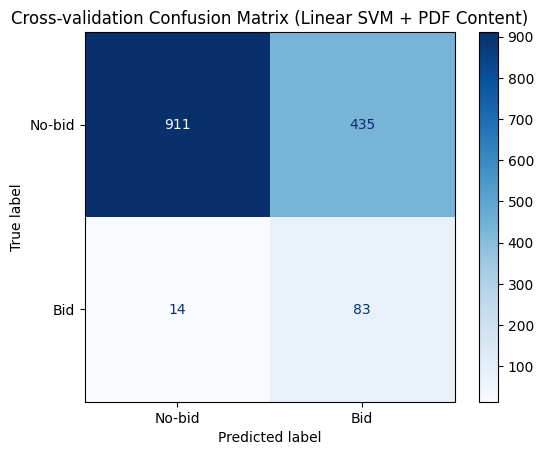


PDF Content Impact Analysis:
Documents with codes: 167
Documents with codes and bid=1: 61
Code-based recall: 0.629


In [5]:
# 5-fold stratified cross-validation with PDF content
print("Running 5-fold stratified cross-validation with PDF content...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

proba = cross_val_predict(
    calibrated, X, y, cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]

# Find threshold to hit recall target
thr = threshold_for_recall(proba, y, recall_target=0.85)
print(f"Chosen threshold to hit recall ≥0.85  →  {thr:.3f}")

y_pred = (proba >= thr).astype(int)

print("\nCross-validation results with PDF content:")
print(classification_report(y, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(
    y, y_pred, display_labels=["No-bid", "Bid"], cmap="Blues"
)
plt.title("Cross-validation Confusion Matrix (Linear SVM + PDF Content)")
plt.show()

# Compare with code-based predictions
print(f"\nPDF Content Impact Analysis:")
print(f"Documents with codes: {df['has_codes'].sum()}")
print(f"Documents with codes and bid=1: {df[(df['has_codes']==1) & (df['bid']==1)].shape[0]}")
print(f"Code-based recall: {df[(df['has_codes']==1) & (df['bid']==1)].shape[0] / df[df['bid']==1].shape[0]:.3f}")

Training set: 1154 samples
Test set: 289 samples
Test set positive class ratio: 0.066

Fitting enhanced Linear SVM with PDF content...


/mnt/c/Users/rober/GitHub/module_2/python/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/c/Users/rober/GitHub/module_2/python/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model fitted successfully!

Test set evaluation:
              precision    recall  f1-score   support

           0      0.989     0.674     0.802       270
           1      0.162     0.895     0.274        19

    accuracy                          0.689       289
   macro avg      0.576     0.784     0.538       289
weighted avg      0.935     0.689     0.767       289



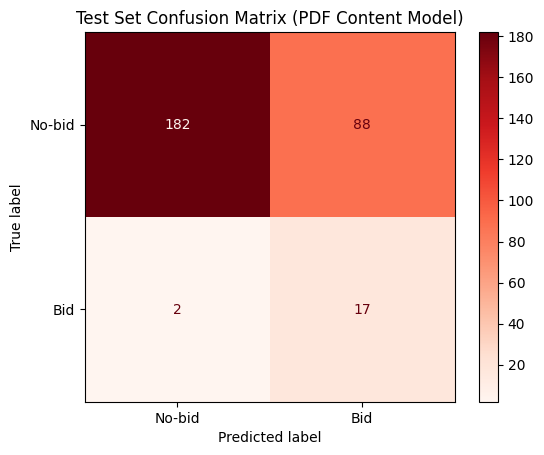


PDF Content Model Results:
→ True Positives: 17
→ False Positives: 88
→ False Negatives: 2
→ True Negatives: 182
→ Test Recall: 0.895
→ Test Precision: 0.162
→ Documents to review: 105

Code Analysis:
Total unique codes: 52
Top 5 most frequent codes:
       code  frequency  percentage
0  72000000         54    3.742204
1  72224000         32    2.217602
2  72200000         31    2.148302
3  48000000         28    1.940402
4  72600000         22    1.524602


In [6]:
# Train/test split for detailed analysis
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Test set positive class ratio: {y_test.mean():.3f}")

# Fit the enhanced model
print("\nFitting enhanced Linear SVM with PDF content...")
calibrated.fit(X_train, y_train)
print("Model fitted successfully!")

# Get test predictions
proba_test = calibrated.predict_proba(X_test)[:, 1]
y_pred_test = (proba_test >= thr).astype(int)

print("\nTest set evaluation:")
print(classification_report(y_test, y_pred_test, digits=3))

# Show confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test, display_labels=["No-bid", "Bid"], cmap="Reds"
)
plt.title(f"Test Set Confusion Matrix (PDF Content Model)")
plt.show()

# Enhanced analysis
print(f"\nPDF Content Model Results:")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
print(f"→ True Positives: {tp}")
print(f"→ False Positives: {fp}")
print(f"→ False Negatives: {fn}")
print(f"→ True Negatives: {tn}")
print(f"→ Test Recall: {tp/(tp+fn):.3f}")
print(f"→ Test Precision: {tp/(tp+fp):.3f}")
print(f"→ Documents to review: {tp + fp}")

# Code statistics
print(f"\nCode Analysis:")
code_stats = get_code_statistics(df)
print(f"Total unique codes: {len(code_stats)}")
print(f"Top 5 most frequent codes:")
print(code_stats.head(5))

## 🎯 Key Improvements with PDF Content

**Enhanced Features:**
1. **PDF Text Analysis**: Uses extracted "5 Lot" sections for more relevant content
2. **Code Detection**: One-hot encoded detected codes as binary features
3. **Content Filtering**: Only includes tenders with actual PDF content
4. **Feature Engineering**: PDF text length, code density, and text ratios

**Data Quality:**
- Filtered to only include tenders with PDF text content
- Minimum PDF text length threshold for quality assurance
- Enhanced feature set with code-based features

**Model Architecture:**
- Dual TF-IDF vectorizers for title and PDF content
- Integrated code detection features
- Enhanced numerical features from text analysis

**5 Lot Section Extraction:**
The `extract_lot_section()` function in `db_utils_pdf_content.py` uses regex patterns to extract:
- Pattern 1: `(?i)(?:^|\n)\s*5\s+lot.*?(?=(?:^|\n)\s*6\s+|\Z)` - Matches "5 Lot" heading
- Pattern 2: `(?i)(?:^|\n)\s*5\.\d+.*?(?=(?:^|\n)\s*6\.\d+|\Z)` - Matches 5.x.x sections

**Business Impact:**
- More targeted document review based on actual content
- Code-based insights for bid opportunity identification
- Improved precision through content-aware filtering